<a href="https://colab.research.google.com/github/Grandediw/ml-algorthm/blob/main/Transformers_model_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D

# Suppress TensorFlow warnings
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

# 1. Data Collection and Preprocessing

# Download the data
ticker = 'MSFT'
data = yf.download(ticker, start='2008-01-01', end='2023-10-01')  # Updated end date

# Use additional features
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Handle missing values
data.dropna(inplace=True)

# Feature Engineering: Add technical indicators
data['MA_7'] = data['Close'].rolling(window=7).mean()
data['MA_21'] = data['Close'].rolling(window=21).mean()
data['EMA_7'] = data['Close'].ewm(span=7, adjust=False).mean()
data['EMA_21'] = data['Close'].ewm(span=21, adjust=False).mean()
data['STD_7'] = data['Close'].rolling(window=7).std()
data['STD_21'] = data['Close'].rolling(window=21).std()

# Relative Strength Index (RSI)
delta = data['Close'].diff(1)
delta = delta.dropna()
up = delta.copy()
down = delta.copy()
up[up < 0] = 0
down[down > 0] = 0
time_period = 14
avg_gain = up.rolling(window=time_period).mean()
avg_loss = abs(down.rolling(window=time_period).mean())
rs = avg_gain / avg_loss
rsi = 100.0 - (100.0 / (1.0 + rs))
data['RSI'] = rsi

# Bollinger Bands
data['Upper_band'] = data['MA_21'] + (data['STD_21'] * 2)
data['Lower_band'] = data['MA_21'] - (data['STD_21'] * 2)

# Drop rows with NaN values created by rolling calculations
data.dropna(inplace=True)

# Select features and target
features = data.drop(['Close'], axis=1)
target = data['Close']

# Scale the features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target.values.reshape(-1, 1))

# Prepare sequences
def create_sequences(features, target, time_step):
    X = []
    y = []
    for i in range(time_step, len(features)):
        X.append(features[i - time_step:i])
        y.append(target[i])
    return np.array(X), np.array(y)

# Parameters
time_step = 60
X, y = create_sequences(scaled_features, scaled_target, time_step)

# Split the data into training and testing sets (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

[*********************100%***********************]  1 of 1 completed


In [ ]:
# 2. Build the Transformer Model

# Positional Encoding Function
def positional_encoding(seq_length, d_model):
    angles = np.arange(seq_length)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    pos_encoding = np.zeros((seq_length, d_model))
    pos_encoding[:, 0::2] = np.sin(angles[:, 0::2])  # Apply sin to even indices
    pos_encoding[:, 1::2] = np.cos(angles[:, 1::2])  # Apply cos to odd indices
    return tf.cast(pos_encoding, dtype=tf.float32)

# Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])

    # Feed Forward Network
    x_ff = LayerNormalization(epsilon=1e-6)(x)
    x_ff = Dense(ff_dim, activation='relu')(x_ff)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = Add()([x_ff, x])
    return x

# Build the model
input_shape = X_train.shape[1:]
inputs = Input(shape=input_shape)
# Add positional encoding
pos_encoding = positional_encoding(input_shape[0], input_shape[1])
x = inputs + pos_encoding

# Transformer blocks
for _ in range(3):  # Increased number of layers
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1)(x)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error')

# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 60, 13)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 60, 13)         │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_6     │ (None, 60, 13)         │             26 │ add_7[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_3    │ (None, 60, 13)         │         14,093 │ layer_normalization_6… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 60, 13)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 60, 13)         │              0 │ dropout_11[0][0],      │
│                           │                        │                │ add_7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_7     │ (None, 60, 13)         │             26 │ add_8[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 60, 128)        │          1,792 │ layer_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 60, 128)        │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 60, 13)         │          1,677 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 60, 13)         │              0 │ dense_9[0][0],         │
│                           │                        │                │ add_8[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_8     │ (None, 60, 13)         │             26 │ add_9[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_4    │ (None, 60, 13)         │         14,093 │ layer_normalization_8… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 60, 13)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 60, 13)         │              0 │ dropout_14[0][0],      │
│                           │                        │                │ add_9[0][0]            │
├──────────────────────

 Total params: 53,803 (210.17 KB)

 Trainable params: 53,803 (210.17 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# 3. Train the Model

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# 4. Evaluate the Model

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
train_predictions_inverse = target_scaler.inverse_transform(train_predictions)
y_train_inverse = target_scaler.inverse_transform(y_train)
test_predictions_inverse = target_scaler.inverse_transform(test_predictions)
y_test_inverse = target_scaler.inverse_transform(y_test)

# Compute Evaluation Metrics
def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

train_rmse = np.sqrt(mean_squared_error(y_train_inverse, train_predictions_inverse))
test_rmse = np.sqrt(mean_squared_error(y_test_inverse, test_predictions_inverse))
train_mae = mean_absolute_error(y_train_inverse, train_predictions_inverse)
test_mae = mean_absolute_error(y_test_inverse, test_predictions_inverse)
train_mape = mean_absolute_percentage_error(y_train_inverse, train_predictions_inverse)
test_mape = mean_absolute_percentage_error(y_test_inverse, test_predictions_inverse)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Train MAPE: {train_mape}%")
print(f"Test MAPE: {test_mape}%")

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 174ms/step - loss: 0.0438 - val_loss: 0.0416
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 176ms/step - loss: 0.0038 - val_loss: 0.0085
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 170ms/step - loss: 0.0020 - val_loss: 0.0054
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 22s 181ms/step - loss: 0.0016 - val_loss: 0.0038
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - loss: 0.0011 - val_loss: 0.0039
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step - loss: 0.0011 - val_loss: 0.0041
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - loss: 8.4076e-04 - val_loss: 0.0072
Epoch 9/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 22s 184ms/step - loss: 8.0264e-04 - val_loss: 0.0114
Epoch 10/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - loss: 8.6348e-04 - val_loss: 0.0115
Epoch 11/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - loss: 8.6806e-04 - val_loss: 0.0133
Epoch 12/20
98/98 ━━━━━━━

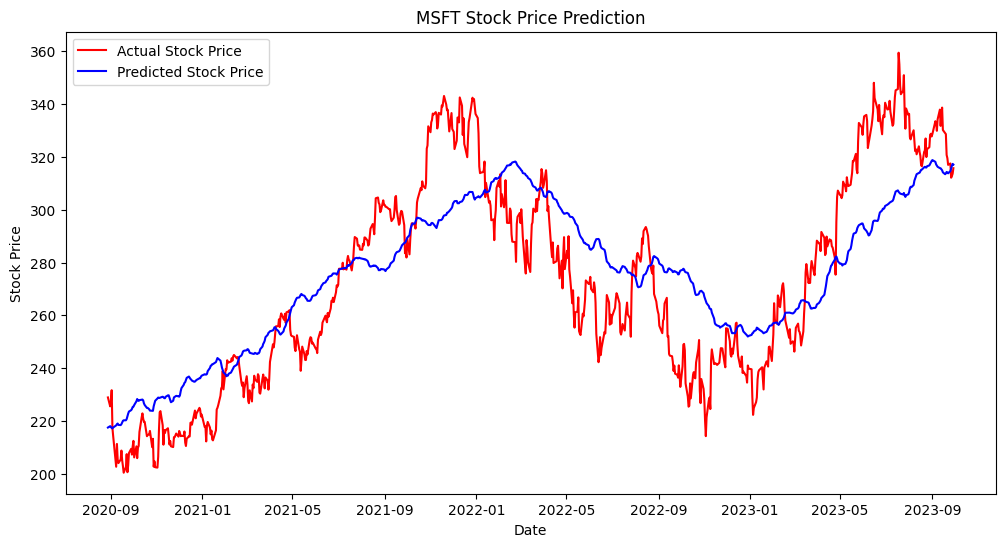

In [ ]:
# 5. Visualize the Results

# Prepare dates for plotting
dates = data.index[-len(y_test_inverse):]

plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_inverse.flatten(), color='red', label='Actual Stock Price')
plt.plot(dates, test_predictions_inverse.flatten(), color='blue', label='Predicted Stock Price')
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

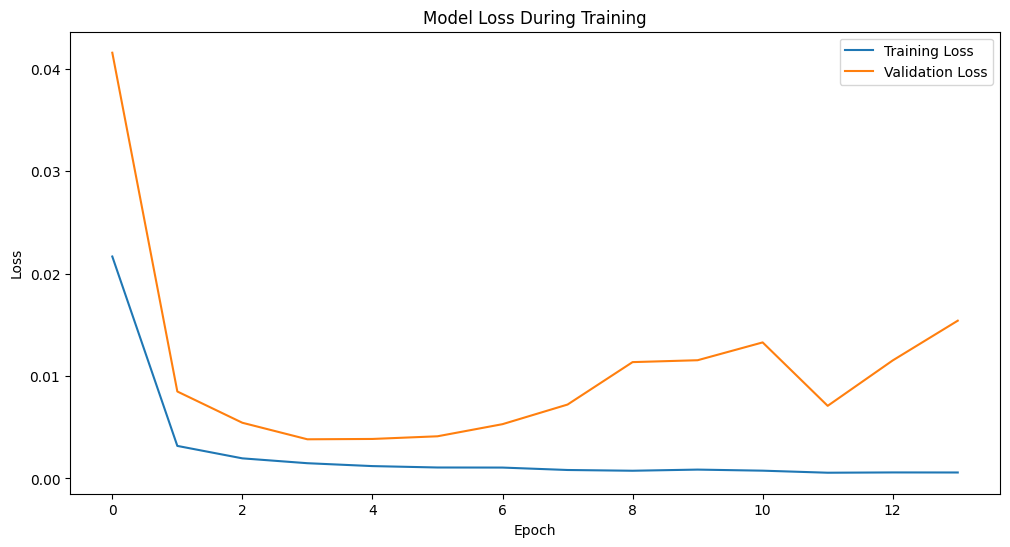

In [ ]:

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()